In [1]:
import numpy as np
from util import *

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import sklearn.linear_model

from scipy.stats import spearmanr as cor

from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Merge
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.layers import Concatenate
from keras.models import load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
from datetime import datetime

# Some functions that you need for processing data.

In [3]:
def readentry(line):
    temp = line.rstrip().split(",")
    return float(temp[1]), float(temp[2]), float(temp[3]), float(temp[4])

In [4]:
def gettime(line):
    temp = [int(i) for i in line.split(" ")[0].split("-")+line.split(" ")[1].split(":")][:-1]
    return datetime(*temp)

In [5]:
def readduka(filename, resolution=60):
    raw = np.array([i.rstrip().split(",") for i in open(filename, "r").readlines()])
    data = raw[:,1:].astype(float)
    
    # base time:
    base = datetime(2010, 1, 1)
    temp = [gettime(i)-base for i in raw[:, 0]]
    time = np.array([i.days*24*resolution+i.seconds/resolution for i in temp])
    day = np.array([i.seconds/60/60/4 for i in temp])
    return data, time, day, raw[:, 0]

In [6]:
def differ(data, x=1):
    for j in range(x):
        ret = np.zeros((data.shape[0]-1, data.shape[1]))
        for i in range(data.shape[0]-1):
            ret[i] = data[i+1]-data[i]
        data = ret
    return data
test = np.arange(12).reshape((3,4))
assert np.sum(differ(test)) == 32

The function below removes the lines that are not common in all features.

In [109]:
def get_uncommon_index_from_ordered_list_of_lists(listoflists, debug=0):
    lol = listoflists
    indexes = [0]*len(lol)
    removal = [[] for i in range(len(indexes))]
    while sum([indexes[i] >= len(lol[i]) for i in range(len(indexes))])==0:
        if debug: print indexes, [lol[i][indexes[i]] for i in range(len(indexes))]
        _max = max([lol[i][indexes[i]] for i in range(len(indexes))])
        for k in range(len(indexes)):
            while indexes[k] < len(lol[k]) and not lol[k][indexes[k]] >= _max:
                removal[k].append(indexes[k])
                indexes[k] += 1
        if sum([indexes[i] >= len(lol[i]) for i in range(len(indexes))])==0\
        and len(list(set([lol[i][indexes[i]] for i in range(len(indexes))]))) == 1:
            for j in range(len(indexes)): indexes[j] += 1
    return removal

In [131]:
def process_data(filenames, fxnames, resolution=60, suffix="test"):
    ## read in data
    data = {}
    times = {}
    hours = {}
    raws = {}
    count = 0
    for filename in filenames:
        tempdata, time, hour, raw = readduka(filename, resolution)
        
        # Invert if USD comes first
        if fxnames[count][:3] == "USD": 
            tempdata = 1.0/tempdata
            temp = tempdata[:, 2]
            tempdata[:, 2] = tempdata[:, 3]
            tempdata[:, 3] = temp
        
        data[fxnames[count]] = tempdata
        times[fxnames[count]] = time
        hours[fxnames[count]] = hour
        raws[fxnames[count]] = raw
        count+=1
        
    ## remove entries that are empty
    removethese = get_uncommon_index_from_ordered_list_of_lists([times[fn] for fn in fxnames])
    count = 0
    for i in removethese:
        print "removing", len(i)
        '''
        print "removing", len(i)
        for j in i:
            temp = np.sum([raws[fxnames[count]][j] not in raws[fxnames[k]] for k in range(7)])
            if temp==0: print times[fxnames[count]][j], temp
        print
        '''
        count +=1
    np.save("removethese."+suffix, removethese)

    for i in range(len(fxnames)):
        mask = np.ones(data[fxnames[i]].shape[0]).astype(np.bool_)
        mask[removethese[i]] = False
        data[fxnames[i]] = data[fxnames[i]][mask]
        times[fxnames[i]] = times[fxnames[i]][mask]
        hours[fxnames[i]] = hours[fxnames[i]][mask]
    
    #returns (t+1)-t
    returns = np.zeros((data[fxnames[i]].shape[0]-1, len(fxnames)))
    for i in range(len(fxnames)):
        returns[:, i] = np.divide(differ(data[fxnames[i]][:, :1])[:,0], data[fxnames[i]][:-1,0])
        #returns[:, i] = np.divide(data[fxnames[i]][:,:1]-data[fxnames[i]][:,0], data[fxnames[i]][:,0])
        
    #spreads 
    spreads = np.square(returns)
    
    #binary up downs
    ups = (returns>0).astype(np.int_)
    downs = (returns<0).astype(np.int_)
    
    #what time during a day 
    timeframe = np.zeros((data[fxnames[i]].shape[0]-1, len(fxnames)))
    for i in range(len(fxnames)):
        timeframe[:, i] = hours[fxnames[i]][:-1]/6
         
    final = np.concatenate([returns, spreads, ups, downs, timeframe], axis=1) #ignore timeframe for now
    return final, data, times

# Loading parameters

We are looking at 1 min and 5 mins candle data for 7 majors foreing exchange rates

In [132]:
majors = ["USDJPY", "USDCHF", "USDCAD", "NZDUSD", "GBPUSD", "EURUSD", "AUDUSD"]

In [133]:
_1min = ["../data/forex_majors_candle/1m/"+m+"-2017_06_01-2017_06_26.csv" for m in majors]
_5min = ["../data/forex_majors_candle/5m/"+m+"-2017_01_01-2017_07_03.csv" for m in majors]

In [134]:
_1min_final, _1mindata, dmy = process_data(_1min, majors, 60)

removing 4
removing 4
removing 1
removing 4
removing 4
removing 4
removing 3


In [135]:
_5min_final, _5mindata, times = process_data(_5min, majors, 12)

removing 299
removing 300
removing 300
removing 276
removing 300
removing 300
removing 300


# Looking at the data

1 minute resolution

2017 June: major foreign exchange rate


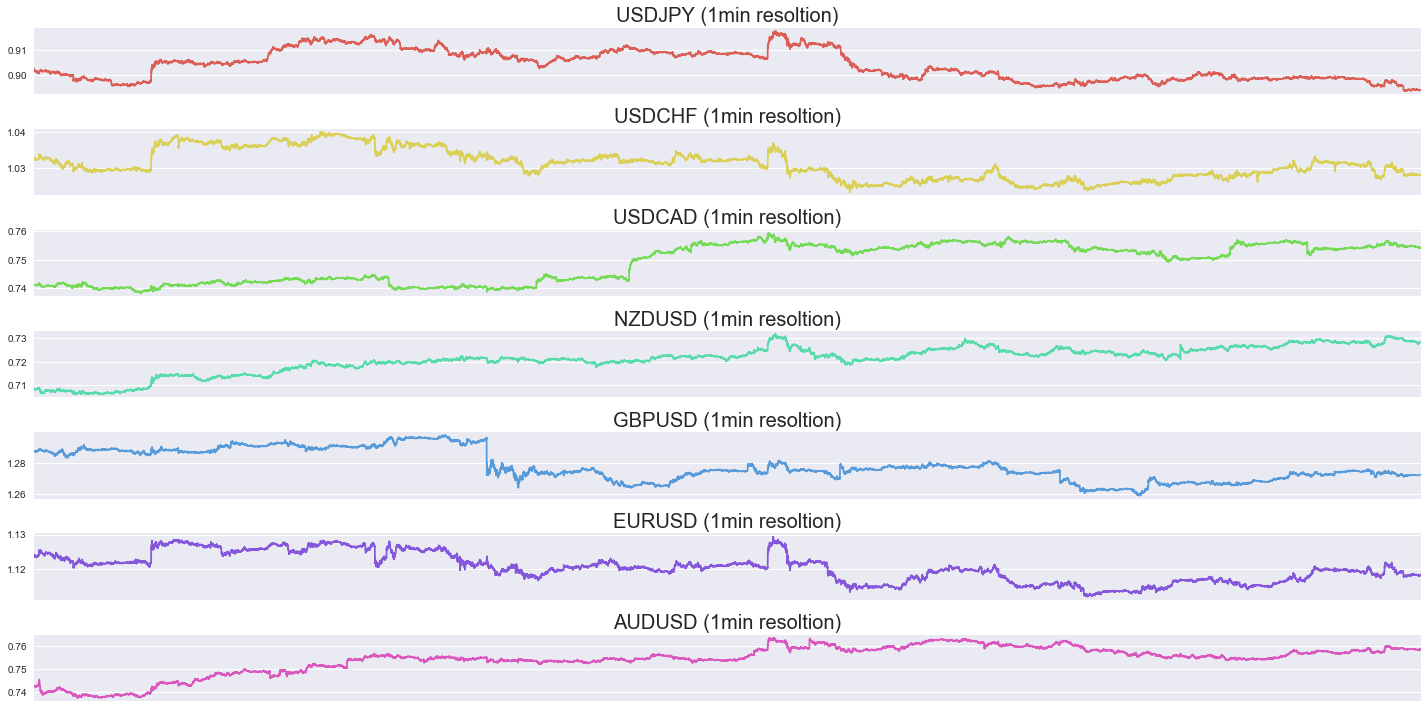

In [1267]:
print "2017 June: major foreign exchange rate"
plt.figure(figsize=(20,10))
count = 1
colors = sns.color_palette("hls", len(majors))
for m in majors:
    plt.subplot(len(majors),1, count)
    plt.plot(_1mindata[m][:,0], color=colors[count-1])
    count += 1
    plt.xticks([],[])
    plt.xlim(0,len(_1mindata[m][:,0]))
    plt.title(m+" (1min resoltion)",fontsize=20)
plt.tight_layout()
plt.show()

5 minute resolution

2017 Jan-June: major foreign exchange rate


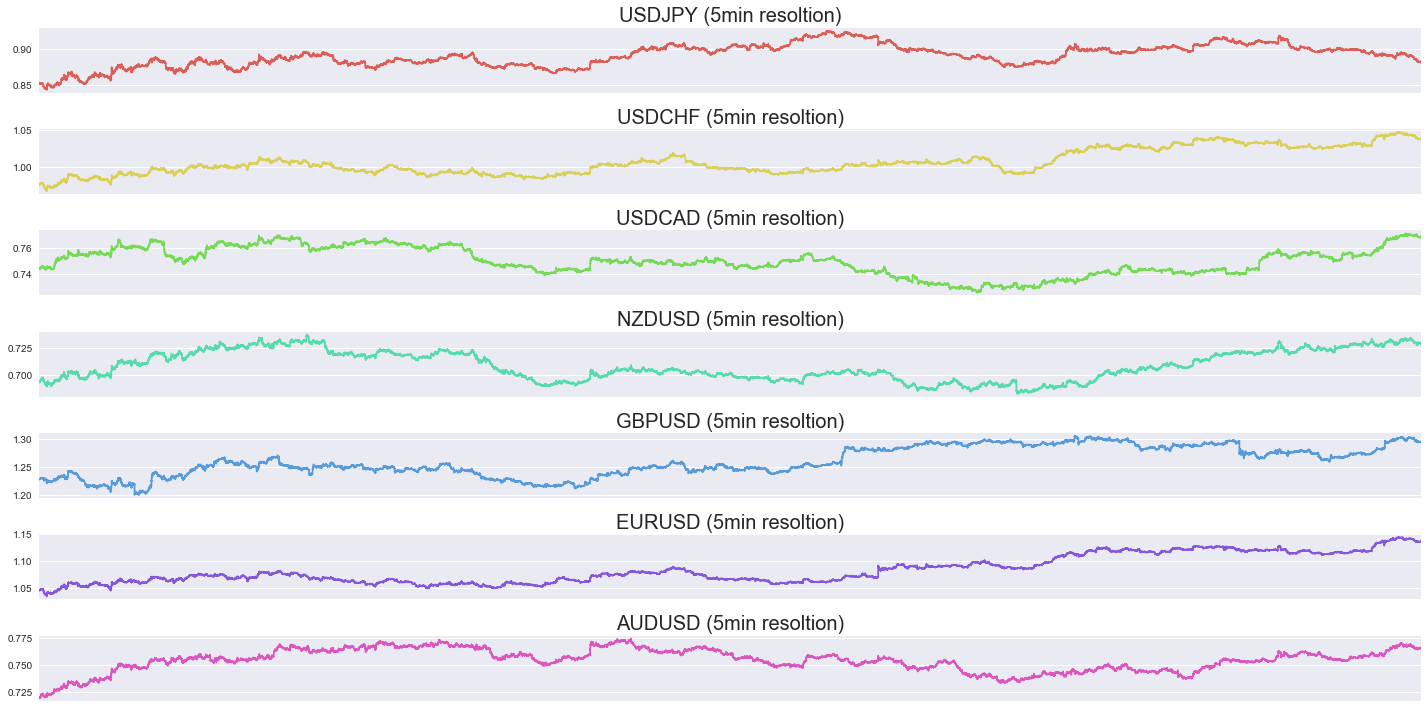

In [1268]:
print "2017 Jan-June: major foreign exchange rate"
plt.figure(figsize=(20,10))
count = 1
colors = sns.color_palette("hls", len(majors))
for m in majors:
    plt.subplot(len(majors),1, count)
    plt.plot(_5mindata[m][:,0], color=colors[count-1])
    count += 1
    plt.xticks([],[])
    plt.xlim(0,len(_5mindata[m][:,0]))
    plt.title(m+" (5min resoltion)",fontsize=20)
plt.tight_layout()
plt.show()

2017 Jan-June: major foreign exchange rate (1st order difference)


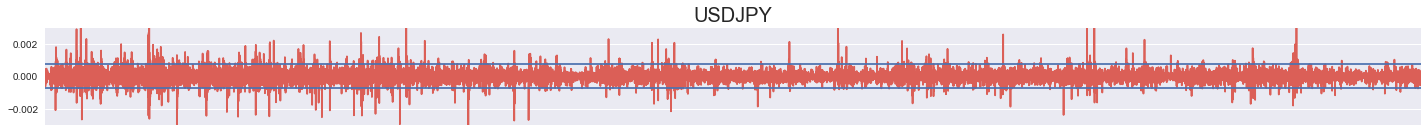

In [136]:
bigbumpth = 0.00075
print "2017 Jan-June: major foreign exchange rate (1st order difference)"
plt.figure(figsize=(20,2))
count = 1
colors = sns.color_palette("hls", len(majors))
for m in majors[:1]:
    plt.subplot(1,1, count)
    plt.plot(_5mindata[m][:, 1]-_5mindata[m][:, 0], color=colors[count-1])
    count += 1
    plt.xticks([],[])
    plt.title(m,fontsize=20)
    plt.axhline(bigbumpth)
    plt.axhline(-1*bigbumpth)
    plt.ylim(-0.003, 0.003)
    plt.xlim(0, len(_1mindata[m][:, 1]))
plt.tight_layout()
plt.show()

# Formulating a prediction problem and generative samples.

What do we predict?
- regress against future values --> probably bad
- classify whether the price will go up in the future or not --> random frucutuation might kill the model.
- classify if there is going to be big upward/downward change or no change in 5 mins?

For the "big"-ness. We choose 2 as a therhsold for mean 0 variance 1 data.
This is equiavalent to looking at p=0.05 movements.

Features?
We have two types of features:
    - 5 minute resolution features
    - 1 hour aggreagate features
For both featuer sets, we look at:
    - past 300 steps of returns (about a day, and 12 days worth of information)
    - past 300 steps of volatility
    - past 300 steps of up and down binary signal
    - time within a day

In [137]:
#data = generate_data(testnames, majors, "test")
_1min_scaled = preprocessing.scale(_1min_final)
_5min_scaled = preprocessing.scale(_5min_final)

In [138]:
curdata = _5min_scaled

In [139]:
def generate_sampleindex(data, target=0, th=2, barrier=20, paststeps=300, futuresteps=1, factor=12):
    majors = ["USDJPY", "USDCHF", "USDCAD", "NZDUSD", "GBPUSD", "EURUSD", "AUDUSD"]
    print "Predicting the movement of", majors[0]
    
    upindex = [i for i in range(data.shape[0]) if data[i, target] > th and i > paststeps*factor+futuresteps]  
    downindex = [i for i in range(data.shape[0]) if data[i, target] < -1*th and i > paststeps*factor+futuresteps] 
    
    mask = np.ones(data.shape[0]).astype(np.bool_)
    for i in upindex+downindex:
        for j in range(max(i-barrier, 0), min(i+barrier, data.shape[0])):
            mask[j] = False
    
    negativeindex = np.arange(data.shape[0])[mask]
    np.random.shuffle(negativeindex)
    negativeindex = [i for i in negativeindex if i > paststeps*factor+futuresteps]
    negativeindex = negativeindex[:(len(upindex)+len(downindex))/2]
    negativeindex.sort()
    
    return upindex, downindex, negativeindex

In [140]:
up, down, neg = generate_sampleindex(curdata, th=3, factor=36)

Predicting the movement of USDJPY


In [143]:
def aggregate_samples(X, factor=12):
    assert X.shape[0]%factor == 0
    ret = np.zeros((X.shape[0]/factor, X.shape[1]))
    for i in range(ret.shape[0]):
        ret[i] = np.mean(X[i*factor:(i+1)*factor, :], axis=0)
    return ret

In [144]:
def generate_samples(data, indexlist, target=0, paststeps=300, futuresteps=1, factor1=12, factor2=36, suffix=""):
    label = ["up", "down", "negative"]
    count2 =0
    Xs =[]
    X2s = []
    X3s = []
    Ys = []
    YRs = []
    
    for indexes in indexlist:
        X = np.zeros((len(indexes), paststeps, data.shape[1]))
        X2 = np.zeros((len(indexes), paststeps, data.shape[1]))
        X3 = np.zeros((len(indexes), paststeps, data.shape[1]))
        Y = np.zeros((len(indexes), 3))
        YR = np.zeros(len(indexes))
        Y[:, count2] = 1
        count2 += 1
        
        count = 0
        for i in indexes:
            X[count] = data[i-paststeps-futuresteps+1:i-futuresteps+1]
            X2[count] = aggregate_samples(data[i-paststeps*factor1-futuresteps+1:i-futuresteps+1], factor1)
            X3[count] = aggregate_samples(data[i-paststeps*factor2-futuresteps+1:i-futuresteps+1], factor2)
            YR[count] = data[i][target]
            count += 1
        Xs.append(X)
        X2s.append(X2)
        X3s.append(X3)
        Ys.append(Y)
        YRs.append(YR)
        
    np.save("Y"+suffix, np.concatenate(Ys, axis=0))
    np.save("YR"+suffix, np.concatenate(YRs, axis=0))
    np.save("X"+suffix, np.concatenate(Xs, axis=0))
    np.save("X2"+suffix, np.concatenate(X2s, axis=0))
    np.save("X3"+suffix, np.concatenate(X3s, axis=0))

In [145]:
generate_samples(_5min_final, [up, down, neg])

(107, 300, 35)
(96, 300, 35)
(101, 300, 35)


# Taking a look at upward direction samples

The visualization of some "up" prediction samples.  
The time step that we are predicting is indicated with red dotted lines.  
The threshold for "significant" movement is defined with the solid gray lines.  

In [146]:
print up[:10], len(up)
print down[:10], len(down)

[10813, 10816, 11427, 11542, 11694, 11709, 11739, 11740, 11839, 11843] 107
[10812, 11127, 11465, 11543, 11721, 11735, 11784, 11788, 11857, 11863] 96


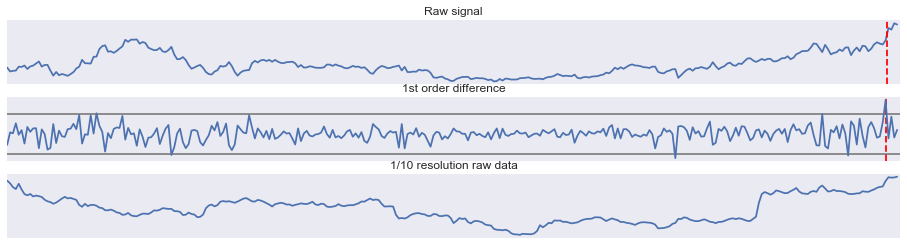

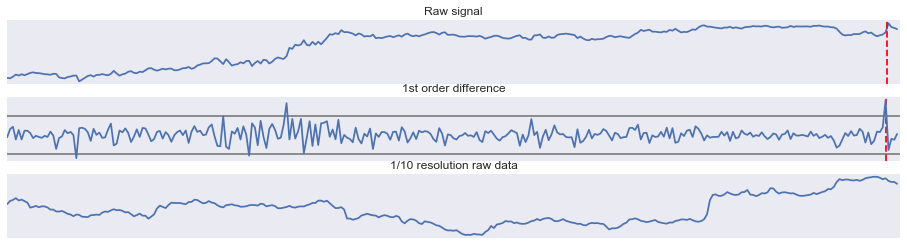

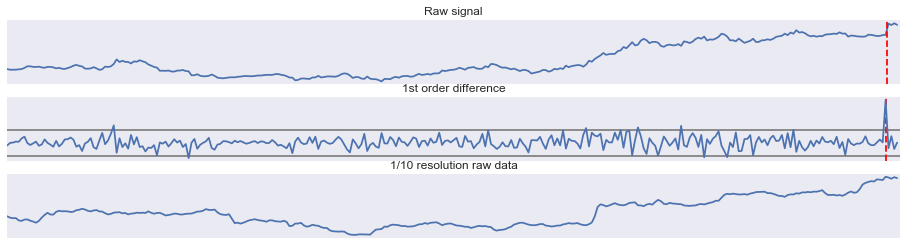

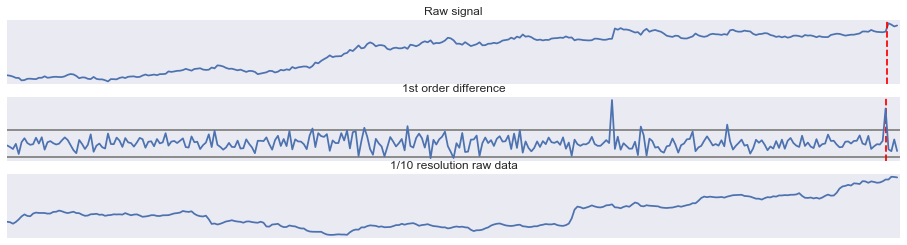

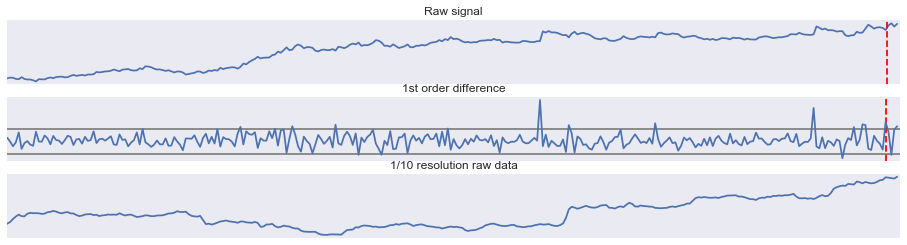

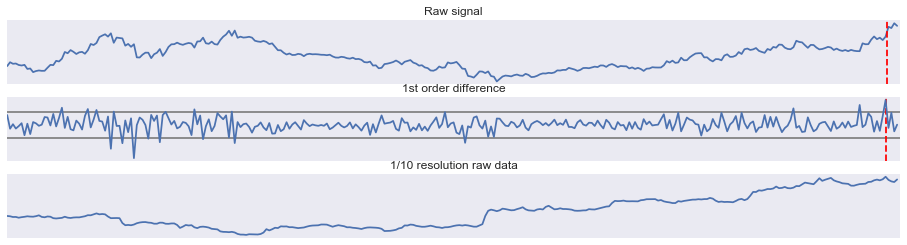

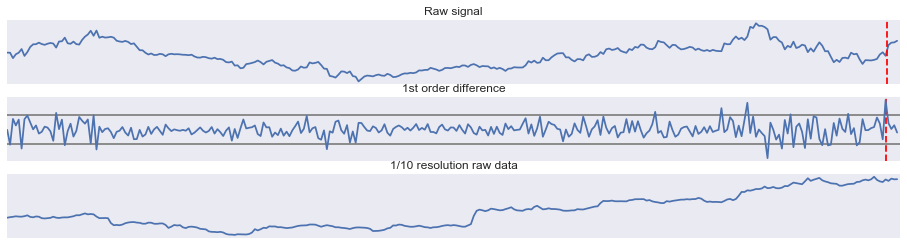

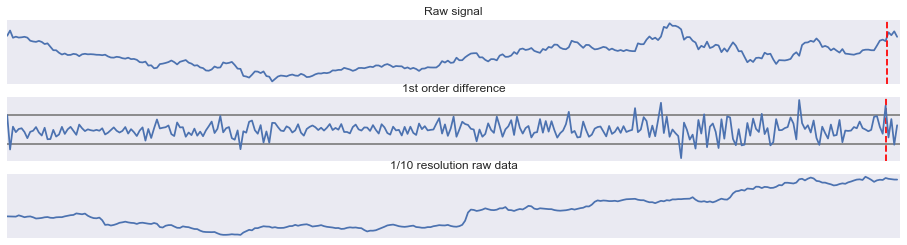

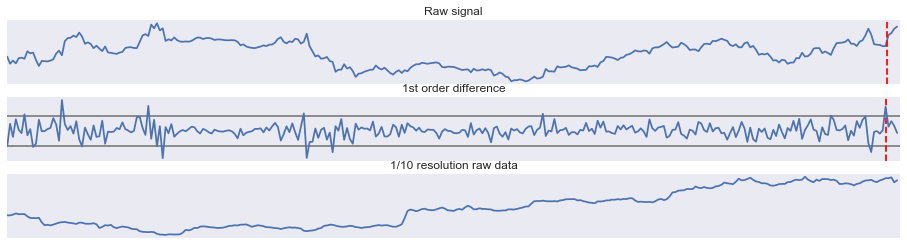

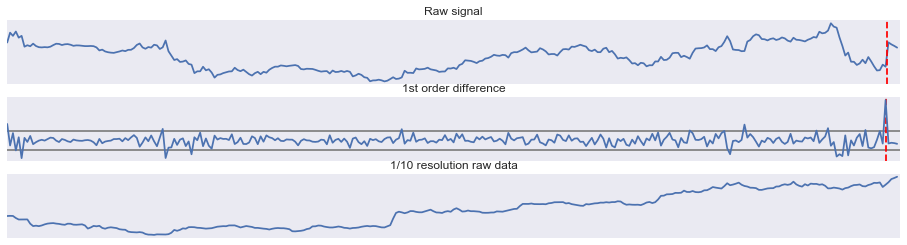

In [147]:
for i in up[20:30]:
    temp = _5mindata["USDJPY"][i-305:i+5,0]
    plt.figure(figsize=(16,4))
    
    plt.subplot(3,1,1)
    plt.title("Raw signal")
    plt.xlim(-5, 305)
    plt.yticks([], [])
    plt.xticks([], [])
    plt.plot(range(-5, 305, 1), temp)
    plt.axvline(300.5, color="red", ls="--")
    
    plt.subplot(3,1,2)
    plt.title("1st order difference")
    plt.xlim(-5, 305)
    plt.yticks([], [])
    plt.xticks([], [])
    plt.axhline(2, color="gray")
    plt.axhline(-2, color="gray")
    plt.axvline(300, color="red", ls="--")
    plt.plot(range(-5, 305, 1), _5min_scaled[i-305:i+5,0])
    
   # print aggregate_samples(_5mindata["USDJPY"][i-305*12:i+5*12,:1]).shape
    plt.subplot(3,1,3)
    plt.title("1/10 resolution raw data")
    plt.xlim(-5, 305)
    plt.yticks([], [])
    plt.xticks([], [])
    plt.plot(range(-5, 305, 1), aggregate_samples(_5mindata["USDJPY"][i-305*12:i+5*12,:1]))
    plt.show()